## 1. Implementation for CycleGAN
>
>
> <img src="https://drive.google.com/uc?id=1v8LUzqE7qjQnN_HtuO4bP9hogq2FVyyp" alt="no_image" style="width: 800px;"/><br>
>
> * Cycle GAN leverages a cycle consistency in image-to-image translation
> * Unlike a conditional GAN, the cycle GAN considers <U>unpaired training data</U>
>
> **1. Dataset**
>
>   * MNIST dataset
>   * SVHN dataset
>   * Note that the MNIST data is gray, where the number of the channel is 1
>
> **2. Network architecture**
>
>   * **Overall architecture**
>
> <img src="https://drive.google.com/uc?id=1YExtjmpAu57bPkgh6OqEHyMDNj7Wy7Gk" alt="no_image" style="width: 600px;"/><br>
>
>   * **Generative model G**
>     * Xavier initialization (Glorot & Bengio [3])
>       * It makes sure the weights to keep the propagation in a reasonable range through many layers
>       * $V(W)= {2 \over n_{in}+n_{out}}$
>       * Use <code>nn.init.xavier_uniform_</code> for the Xavier initialization
>
>     * The generative model has three components:
>       1. Encoder: 
>         * Convolutional network for feature extracting
>         * 2 convolutional layers and 2 LeakyReLU activations
>         * The output channel sizes are 64, 128 respectively<br>
>         * The kernel size of the convolutional layers are 7 and 3, respectively<br>
>            (You can use different sizes whatever you want, but we recommend those sizes)
>         * All the strides are 2
>         * Use batch normalization except for the first layer
>
>       2. Transformer: 
>         * Learn how it would like to transform the feature vector of and image from A to B. <br> 
>         * Use the resnet blok which contains the skip-connetction between the input and output for transformation<br>
>            (Please refer to <U>He et al.</U>[3])
>         * 3 resnet block layers and each of layer is followed by LeakyReLU activation
>         * All the output channel sizes are 128
>         * All the kernel sizes and strides are 3 and 1, respectively
>      
>       3. Decoder: 
>         * Upconvolutional network for reconstructing an image
>         * 2 upconvolutional layers, one LeakyReLU activations, and one Tanh activation which is for the last layer
>         * The output channel sizes are 128, 64, and 3, respectively for the SVHN data, and 128, 64, and 1, respectively for the MNIST data <br>
>         * All the kernel sizes and strides are 4 and 2, respectively
>         * Use batch normalization except for the last layers
>
>
>
> <img src="https://drive.google.com/uc?id=15pzDH7bCworNtjaJpLPz0aH4_FMtl1Jd" alt="no_image" style="width: 800px;"/><br>
>
>
>   * **Discriminative model D**
>     * Xavier Initialization
>     * It contains 4 convolutional layers, 3 LeakyReLU activations, and one Sigmoid activation which is for the last layer
>     * The output channel sizes are 64, 128, 256, and 1, respectively
>     * All the kernel sizes are 4 except for the last kernel size which is 1
>     * The strides from the first two layers are 2 and the rest of them are 1
>     * Use batch normalization([4]) except for the first and last layers
>
>
>
> <img src="https://drive.google.com/uc?id=1XteTcNDxYiN8CP6XKoZ37jdu1yJNMNXl" alt="no_image" style="width: 600px;"/><br>
>
>
> **3. Loss function**<br>
> (In the paper, the authors use the L2 loss for the GAN loss, but the binary cross entropy loss also works well)
>  * **Discriminative model $D_X$ and $D_Y$**
>    * The loss for $D_Y$ is followed as<br>
>      * Binary cross entropy loss for the real data
>      * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_Y(y_i))+(1-l_i^{real})log(1-D_Y(y_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{fake}log(D_Y(G_Y(x_i)))+(1-l_i^{fake})log(1-D_Y(G_Y(x_i)))$ <br>
>
>  *
>    * The loss for $D_Y$ is followed as<br>
>      * Binary cross entropy loss for the real data
>      * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_X(x_i))+(1-l_i^{real})log(1-D_X(x_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{fake}log(D_X(G_X(y_i)))+(1-l_i^{fake})log(1-D_X(G_X(y_i)))$ <br>
>
>    ($l_i^{real}=1, l_i^{fake}=0$) <br>
>    ($G_Y$ is the generator where $x_i$ translate to $y_i$ and vice versa)
>
>
>  * **Generative model $G_X$ and $G_Y$**<br>
>
>      * Binary cross entropy loss for the real data (It is actually fake)
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_X(G_X(y_i)))+(1-l_i^{real})log(1-D_X(G_X(y_i))) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_Y(G_Y(x_i)))+(1-l_i^{real})log(1-D_Y(G_Y(x_i))) $ <br>
>
>    ($l_i^{real}=1$)
>    
>      * The cycle loss for measuring difference between $x_i$ and $G_Y(G_X(x_i))$ and vice versa
>
>    $-{1 \over N} \sum^{N}_{i=1} \lvert\lvert G_Y(G_X(y_i))-y_i \rvert\rvert_1$ <br>
>    $-{1 \over N} \sum^{N}_{i=1} \lvert\lvert G_X(G_Y(x_i))-x_i \rvert\rvert_1$

## 2. Cycle GAN with Pytorch

In [2]:
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Parameter Setting
* You can adjust the parameters to yourself

In [3]:
print('STEP 0: PARAMETER SETTING')

# Data root directory
train_X_root = 'dataset/lab14/mnist/'
train_Y_root = 'dataset/lab14/svhn/'

# Weight save directory
vis_num = 2
save_dir = 'cyclegan'
if not osp.exists(save_dir):
    os.makedirs(save_dir)

# Batch size during training
bs = 64

# Size of image
img_height = 32
img_width = 32
img_size = 32
img_channel = 3

# Channels of generator feature
gfc = 64

# Channels of discriminator feature
dfc = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizing
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Real or Fake label
real_label = 1
fake_label = 0

STEP 0: PARAMETER SETTING


In [4]:
print('STEP 1: LOADING DATASET')

transform_1ch = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

transform_3ch = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_X_set = dset.MNIST(root=train_X_root,
                         train=True,
                         transform=transform_1ch,
                         download=False)
train_Y_set = dset.SVHN(root=train_Y_root,
                        split='train',
                        transform=transform_3ch,
                        download=False)
test_X_set = dset.MNIST(root=train_X_root,
                         train=False,
                         transform=transform_1ch,
                         download=False)
test_Y_set = dset.SVHN(root=train_Y_root,
                        split='test',
                        transform=transform_3ch,
                        download=False)

STEP 1: LOADING DATASET


In [5]:
print('STEP 2: MAKING DATASET ITERABLE')

train_X_loader = torch.utils.data.DataLoader(train_X_set,
                                             batch_size=bs, 
                                             shuffle=True,
                                             drop_last=True)

train_Y_loader = torch.utils.data.DataLoader(train_Y_set,
                                             batch_size=bs, 
                                             shuffle=True,
                                             drop_last=True)

test_X_loader = torch.utils.data.DataLoader(test_X_set,
                                             batch_size=bs, 
                                             shuffle=False,
                                             drop_last=True)

test_Y_loader = torch.utils.data.DataLoader(test_Y_set,
                                             batch_size=bs, 
                                             shuffle=False,
                                             drop_last=True)

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

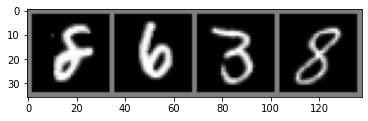

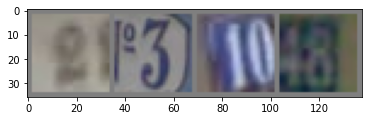

In [7]:
data_loader_X_sample = torch.utils.data.DataLoader(train_X_set,
                                                 batch_size=4, 
                                                 shuffle=True)
data_loader_Y_sample = torch.utils.data.DataLoader(train_Y_set,
                                                 batch_size=4, 
                                                 shuffle=True)

# Get a batch of training data
X = next(iter(data_loader_X_sample))
Y = next(iter(data_loader_Y_sample))

# Make a grid from batch
out_X = torchvision.utils.make_grid(X[0])
out_Y = torchvision.utils.make_grid(Y[0])

imshow(out_X)
imshow(out_Y)

### Utils 
* Use the below code for the convolution or the upconvolution

### *References*
[1] Zhu et al., "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks", *ICCV*, 2017. <br>
[2] https://hardikbansal.github.io/CycleGANBlog/ <br>
[3] Glorot & Bengio, "Understanding the difficulty of training deep feedforward neural networks", *AISTATS* 2010. <br>
[4] Ioffe & Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", *ICML* 2015.

In [8]:
def conv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation.lower() == 'relu':
        layers += [nn.ReLU(inplace=True)]
    if activation.lower() == 'leakyrelu':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation.lower() == 'tanh':
        layers += [nn.Tanh()]
    if activation.lower() == 'sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)
        
def upconv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation.lower() == 'relu':
        layers += [nn.ReLU(inplace=True)]
    if activation.lower() == 'leakyrelu':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation.lower() == 'tanh':
        layers += [nn.Tanh()]
    if activation.lower() == 'sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)

def transpose(ndarray):
    return np.transpose(ndarray, [0,2,3,1])

def gray2rgb(ndarray):
    return np.concatenate((ndarray, ndarray, ndarray), axis=2)

### 2.1 Write the code (Generator) [3 points]
* You need to set the hyperparameters for implementing the upconvolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [9]:
print('STEP 3-1: CREATE MODEL CLASS (Generator)')


# [input channels, output channels, kernel_size, strides, paddings]

cfg_g_enc_X = [[1, 64, 7, 2, 3,'leakyrelu'], [64, 128, 3, 2, 1, 'leakyrelu']]
cfg_g_enc_Y = [[3, 64, 7, 2, 3,'leakyrelu'], [64, 128, 3, 2, 1, 'leakyrelu']]
cfg_g_trans = [[128, 128, 3, 1, 1, 'leakyrelu'], [128, 128, 3, 1, 1, 'leakyrelu'], [128, 128, 3, 1, 1, 'leakyrelu']]
cfg_g_dec_X = [[128, 64, 4, 2, 1, 'leakyrelu'], [64, 3, 4, 2, 1, 'tanh']]
cfg_g_dec_Y = [[128, 64, 4, 2, 1, 'leakyrelu'], [64, 1, 4, 2, 1, 'tanh']]


class Generator_X(nn.Module):
    def __init__(self):
        super(Generator_X, self).__init__()
        
        #############
        self.conv1 = conv2d(cfg_g_enc_X[0], batch_norm = False)
        self.conv2 = conv2d(cfg_g_enc_X[1])
        self.trans1 = conv2d(cfg_g_trans[0])
        self.trans2 = conv2d(cfg_g_trans[1])
        self.trans3 = conv2d(cfg_g_trans[2])
        self.upconv1 = upconv2d(cfg_g_dec_X[0])
        self.upconv2 = upconv2d(cfg_g_dec_X[1], batch_norm = False)
        #############
        
    def forward(self, x):
        
        #############
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + self.trans1(out)
        out = out + self.trans2(out)
        out = out + self.trans3(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
            
        return out
        #############
    
class Generator_Y(nn.Module):
    def __init__(self):
        super(Generator_Y, self).__init__()
        
        #############
        self.conv1 = conv2d(cfg_g_enc_Y[0], batch_norm = False)
        self.conv2 = conv2d(cfg_g_enc_Y[1])
        self.trans1 = conv2d(cfg_g_trans[0])
        self.trans2 = conv2d(cfg_g_trans[1])
        self.trans3 = conv2d(cfg_g_trans[2])
        self.upconv1 = upconv2d(cfg_g_dec_Y[0])
        self.upconv2 = upconv2d(cfg_g_dec_Y[1], batch_norm = False)
        #############
        
        
    def forward(self, x):
        
        #############
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + self.trans1(out)
        out = out + self.trans2(out)
        out = out + self.trans3(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
            
        return out
        #############
        

STEP 3-1: CREATE MODEL CLASS (Generator)


### 2.2 Write the code (Discriminator) [3 points]
* You need to set the hyperparameters for implementing the convolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [10]:
print('STEP 3-2: CREATE MODEL CLASS (Discriminator)')


# [input channels, output channels, kernel_size, strides, paddings]

cfg_d_X = [[1, 64, 4, 2, 13, 'leakyrelu'], [64, 128, 4, 2, 1, 'leakyrelu'], [128, 256, 4, 1, 0, 'leakyrelu'], [256, 1, 4, 1, 0, 'Sigmoid']]
cfg_d_Y = [[3, 64, 4, 2, 13, 'leakyrelu'], [64, 128, 4, 2, 1, 'leakyrelu'], [128, 256, 4, 1, 0, 'leakyrelu'], [256, 1, 4, 1, 0, 'Sigmoid']]


class Discriminator_X(nn.Module):
    def __init__(self):
        super(Discriminator_X, self).__init__()
        
        #############
        self.conv1 = conv2d(cfg_d_X[0], batch_norm = False)
        self.conv2 = conv2d(cfg_d_X[1])
        self.conv3 = conv2d(cfg_d_X[2])
        self.conv4 = conv2d(cfg_d_X[3], batch_norm = False)
        #############
        
    def forward(self, x):
        
        #############
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        
        return out
        #############
    
class Discriminator_Y(nn.Module):
    def __init__(self):
        super(Discriminator_Y, self).__init__()
        
        #############
        self.conv1 = conv2d(cfg_d_Y[0], batch_norm = False)
        self.conv2 = conv2d(cfg_d_Y[1])
        self.conv3 = conv2d(cfg_d_Y[2])
        self.conv4 = conv2d(cfg_d_Y[3], batch_norm = False)
        #############
        
    def forward(self, x):
        
        #############
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        
        return out
        #############
        

STEP 3-2: CREATE MODEL CLASS (Discriminator)


In [11]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model_G_X = Generator_X()
model_G_Y = Generator_Y()
model_D_X = Discriminator_X()
model_D_Y = Discriminator_Y()


#######################
#  USE GPU FOR MODEL  #
#######################


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_G_X.to(device)
print(model_G_X)
model_G_Y.to(device)
print(model_G_Y)
model_D_X.to(device)
print(model_D_X)
model_D_Y.to(device)

STEP 4: INSTANTIATE MODEL CLASS
Generator_X(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (trans1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (trans2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (trans3):

Discriminator_Y(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(13, 13), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
)

In [12]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer_G_X = torch.optim.Adam(model_G_X.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_Y = torch.optim.Adam(model_G_Y.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_X = torch.optim.Adam(model_D_X.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_Y = torch.optim.Adam(model_D_Y.parameters(), lr=lr, betas=(beta1, 0.999))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 2.3 Train the Cycle GAN [4 points]
* After the training is finished, check out the generated samples
* If the samples are generated well, then you will get the full score

STEP 7: TRAIN THE MODEL
it[0100/4685] 	Loss_D:0.9923 	Loss_G:2.3386 	Loss_C:0.3113 	elapsed_time:0.25mins
it[0200/4685] 	Loss_D:0.7897 	Loss_G:2.7514 	Loss_C:0.2309 	elapsed_time:0.47mins
it[0300/4685] 	Loss_D:0.9219 	Loss_G:2.8056 	Loss_C:0.2291 	elapsed_time:0.70mins
it[0400/4685] 	Loss_D:0.8882 	Loss_G:4.3765 	Loss_C:0.2183 	elapsed_time:0.92mins
it[0500/4685] 	Loss_D:0.8770 	Loss_G:4.3298 	Loss_C:0.2356 	elapsed_time:1.15mins
it[0600/4685] 	Loss_D:0.4524 	Loss_G:4.7029 	Loss_C:0.2154 	elapsed_time:1.37mins
it[0700/4685] 	Loss_D:0.6901 	Loss_G:4.2902 	Loss_C:0.2481 	elapsed_time:1.61mins
it[0800/4685] 	Loss_D:0.8081 	Loss_G:4.4086 	Loss_C:0.2416 	elapsed_time:1.83mins
it[0900/4685] 	Loss_D:0.8968 	Loss_G:4.8314 	Loss_C:0.2541 	elapsed_time:2.04mins
it[1000/4685] 	Loss_D:0.7832 	Loss_G:5.0532 	Loss_C:0.2425 	elapsed_time:2.26mins


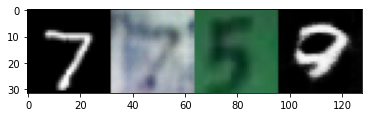

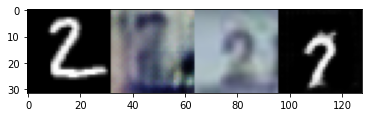

it[1100/4685] 	Loss_D:0.9266 	Loss_G:4.2004 	Loss_C:0.2568 	elapsed_time:2.56mins
it[1200/4685] 	Loss_D:0.5452 	Loss_G:5.6473 	Loss_C:0.2522 	elapsed_time:2.79mins
it[1300/4685] 	Loss_D:0.6631 	Loss_G:3.6845 	Loss_C:0.2639 	elapsed_time:3.02mins
it[1400/4685] 	Loss_D:0.5450 	Loss_G:4.5146 	Loss_C:0.2676 	elapsed_time:3.24mins
it[1500/4685] 	Loss_D:0.7054 	Loss_G:4.8754 	Loss_C:0.2772 	elapsed_time:3.45mins
it[1600/4685] 	Loss_D:0.6636 	Loss_G:4.4061 	Loss_C:0.2945 	elapsed_time:3.68mins
it[1700/4685] 	Loss_D:0.7791 	Loss_G:6.9189 	Loss_C:0.2809 	elapsed_time:3.90mins
it[1800/4685] 	Loss_D:0.8177 	Loss_G:9.0130 	Loss_C:0.2652 	elapsed_time:4.07mins
it[1900/4685] 	Loss_D:0.5951 	Loss_G:5.7735 	Loss_C:0.2677 	elapsed_time:4.22mins
it[2000/4685] 	Loss_D:0.4243 	Loss_G:4.1251 	Loss_C:0.3079 	elapsed_time:4.36mins


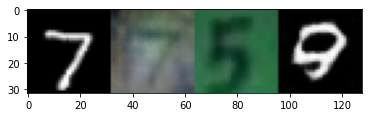

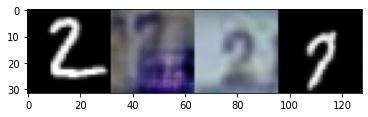

it[2100/4685] 	Loss_D:0.7469 	Loss_G:4.5589 	Loss_C:0.2868 	elapsed_time:4.54mins
it[2200/4685] 	Loss_D:0.4517 	Loss_G:4.8996 	Loss_C:0.2911 	elapsed_time:4.72mins
it[2300/4685] 	Loss_D:0.4786 	Loss_G:5.6677 	Loss_C:0.2830 	elapsed_time:4.95mins
it[2400/4685] 	Loss_D:0.4450 	Loss_G:5.5755 	Loss_C:0.2814 	elapsed_time:5.17mins
it[2500/4685] 	Loss_D:0.4292 	Loss_G:4.9383 	Loss_C:0.2731 	elapsed_time:5.40mins
it[2600/4685] 	Loss_D:0.4351 	Loss_G:4.1575 	Loss_C:0.2872 	elapsed_time:5.61mins
it[2700/4685] 	Loss_D:0.3634 	Loss_G:5.9444 	Loss_C:0.2504 	elapsed_time:5.85mins
it[2800/4685] 	Loss_D:0.6305 	Loss_G:4.6588 	Loss_C:0.2819 	elapsed_time:6.06mins
it[2900/4685] 	Loss_D:0.4298 	Loss_G:7.0352 	Loss_C:0.2521 	elapsed_time:6.27mins
it[3000/4685] 	Loss_D:1.1106 	Loss_G:4.9035 	Loss_C:0.2885 	elapsed_time:6.48mins


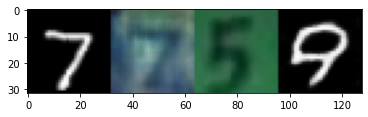

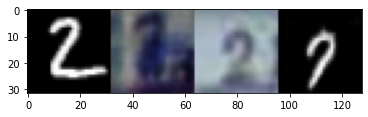

it[3100/4685] 	Loss_D:0.4973 	Loss_G:5.7314 	Loss_C:0.2605 	elapsed_time:6.79mins
it[3200/4685] 	Loss_D:0.4424 	Loss_G:5.0461 	Loss_C:0.2742 	elapsed_time:7.01mins
it[3300/4685] 	Loss_D:0.6378 	Loss_G:4.5247 	Loss_C:0.2483 	elapsed_time:7.24mins
it[3400/4685] 	Loss_D:0.4451 	Loss_G:5.0151 	Loss_C:0.2624 	elapsed_time:7.46mins
it[3500/4685] 	Loss_D:0.3083 	Loss_G:4.6723 	Loss_C:0.3035 	elapsed_time:7.68mins
it[3600/4685] 	Loss_D:0.5021 	Loss_G:5.7189 	Loss_C:0.3244 	elapsed_time:7.90mins
it[3700/4685] 	Loss_D:0.6073 	Loss_G:4.0738 	Loss_C:0.2603 	elapsed_time:8.06mins
it[3800/4685] 	Loss_D:0.5902 	Loss_G:4.3859 	Loss_C:0.2509 	elapsed_time:8.22mins
it[3900/4685] 	Loss_D:0.4882 	Loss_G:4.6147 	Loss_C:0.2604 	elapsed_time:8.38mins
it[4000/4685] 	Loss_D:0.4543 	Loss_G:4.0227 	Loss_C:0.2844 	elapsed_time:8.53mins


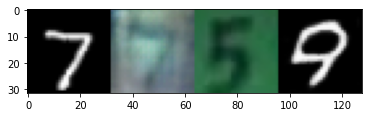

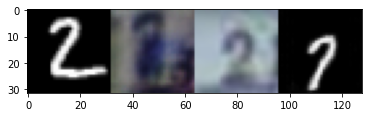

it[4100/4685] 	Loss_D:0.4660 	Loss_G:4.8410 	Loss_C:0.2886 	elapsed_time:8.79mins
it[4200/4685] 	Loss_D:0.9889 	Loss_G:2.4888 	Loss_C:0.2954 	elapsed_time:9.00mins
it[4300/4685] 	Loss_D:0.8354 	Loss_G:7.2185 	Loss_C:0.2831 	elapsed_time:9.21mins
it[4400/4685] 	Loss_D:0.3918 	Loss_G:5.5291 	Loss_C:0.2643 	elapsed_time:9.42mins
it[4500/4685] 	Loss_D:0.7873 	Loss_G:5.2261 	Loss_C:0.2625 	elapsed_time:9.64mins
it[4600/4685] 	Loss_D:0.2562 	Loss_G:5.9265 	Loss_C:0.2967 	elapsed_time:9.85mins


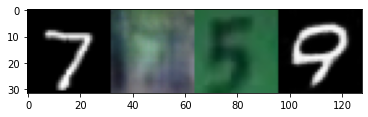

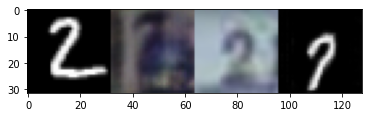

In [13]:
print('STEP 7: TRAIN THE MODEL')

label_real = torch.full((bs, 1, 8, 8), real_label, dtype=torch.float32, device=device)
label_fake = torch.full((bs, 1, 8, 8), fake_label, dtype=torch.float32, device=device)

num_iter = 0
max_iter = num_epochs*len(train_X_loader)

train_start_time = time.time()
for epoch in range(1, num_epochs+1):
    for batch_index, data_X in enumerate(train_X_loader):
        model_G_X.train()
        model_G_Y.train()
        model_D_X.train()
        model_D_Y.train()
        
        data_X = data_X[0].to(device)
        data_Y = next(iter(train_Y_loader))[0].to(device)
        
        ### Update discriminator model
        
        #############

        # Clear gradients w.r.t. parameters
        model_D_X.zero_grad()
        model_D_Y.zero_grad()
        model_D_X.requires_grad = True
        model_D_Y.requires_grad = True
        optimizer_G_X.zero_grad()
        optimizer_G_Y.zero_grad()
        optimizer_D_X.zero_grad()
        optimizer_D_Y.zero_grad()

        # Forward pass to get results of discriminator for real data and fake data
        output_DX_real = model_D_X(data_X)
        output_DY_real = model_D_Y(data_Y)
        fake_X = model_G_Y(data_Y)
        fake_Y = model_G_X(data_X)
        fake_DX = model_D_X(fake_X.detach())
        fake_DY = model_D_Y(fake_Y.detach())
        
        # Calculate Discriminator Loss
        err_DX_real = criterion_GAN(output_DX_real, label_real)
        err_DY_real = criterion_GAN(output_DY_real, label_real)
        err_DX_fake = criterion_GAN(fake_DX, label_fake)
        err_DY_fake = criterion_GAN(fake_DY, label_fake)
        
        # Total discriminator loss
        err_D_X = (err_DX_real + err_DX_fake)*0.5
        err_D_Y = (err_DY_real + err_DY_fake)*0.5       
        err_D = err_D_X + err_D_Y
        
        # Getting gradients w.r.t. parameters
        err_D.backward()
        
        # Updating parameters
        optimizer_D_X.step()
        optimizer_D_Y.step()
        
        #############
        
        
        #############

        ### Update generator model
        
        # Clear gradients w.r.t. parameters
        model_G_X.zero_grad()
        model_G_Y.zero_grad()
        model_D_X.requires_grad = False
        model_D_Y.requires_grad = False
        optimizer_D_X.zero_grad()
        optimizer_D_Y.zero_grad()
        optimizer_G_X.zero_grad()
        optimizer_G_Y.zero_grad()
        
        
        # Forward pass to get results of discriminator for fake data
        output_DX_fake = model_D_X(fake_X)
        output_DY_fake = model_D_Y(fake_Y)
        
        # Calculate Generator Loss
        err_GX = criterion_GAN(output_DX_fake, label_real)
        err_GY = criterion_GAN(output_DY_fake, label_real)
        
        # Total generator loss
        err_G = err_GX + err_GY
                
        # Computing L1 loss
        err_L1_Y = criterion_L1(model_G_X(fake_X), data_Y)
        err_L1_X = criterion_L1(model_G_Y(fake_Y), data_X)
        
        # Total L1 loss
        err_C = err_L1_X + err_L1_Y

        # Total generator loss + cycle loss    
        err_G_C = err_G + 10 * err_C
        
        # Getting gradients w.r.t. parameters
        err_G_C.backward()
        
        # Updating parameters
        optimizer_G_X.step()
        optimizer_G_Y.step()
        
        #############
        
        
        
        num_iter += 1
        # Output training stats
        if num_iter%100 == 0:
            print('it[{:04d}/{:04d}] \tLoss_D:{:.4f} \tLoss_G:{:.4f} \tLoss_C:{:.4f} \telapsed_time:{:.2f}mins'.format(
                num_iter, max_iter, err_D.item(), err_G.item(), err_C.item(), (time.time()-train_start_time)/60 
            ))

        if num_iter%1000==0 or num_iter==max_iter:
            save_name = osp.join(save_dir, 'it{:04d}.pt'.format(num_iter))
            torch.save({
                'model_G_X': model_G_X.state_dict(),
                'model_G_Y': model_G_Y.state_dict()
            }, save_name)
    
            with torch.no_grad():
                model_G_X.eval()
                model_G_Y.eval()
                for test_index, data_X in enumerate(test_X_loader):
                    if test_index == 0:
                        
                        data_X = data_X[0].to(device)
                        data_Y = next(iter(test_Y_loader))[0].to(device)

                        output_X = model_G_X(data_X)
                        output_Y = model_G_Y(data_Y)
                        
                        data_X = ((data_X+1)/2).cpu().data.numpy()
                        data_Y = ((data_Y+1)/2).cpu().data.numpy()

                        output_X = ((output_X + 1)/2).cpu().data.numpy()
                        output_Y = ((output_Y + 1)/2).cpu().data.numpy()
                
                        for vis_idx in range(vis_num):
                            data_X_, data_Y_ = gray2rgb(transpose(data_X)[vis_idx]), transpose(data_Y)[vis_idx]
                            output_X_, output_Y_  = transpose(output_X)[vis_idx], gray2rgb(transpose(output_Y)[vis_idx])
                            outputs = np.concatenate((data_X_, output_X_, data_Y_, output_Y_), axis=1)
                            plt.imshow(outputs)
                            plt.pause(0.001)

## Discussion

> In this week, I made CycleGAN's generator, discriminator and losses. To make them, I needed to calculate appropriate padding size. For making loss formula, I referred to author's code. In that code, they multiplied 0.5 to discriminator loss when they combine real loss and fake loss of each discriminator. So, I did it too. In the result above, 2nd column image is fake image that is made from generator X, which generates svhn image from mnist image. 4th column image is fake image that is made from generator Y, which generates mnist image from svhn image.